# Préparation des données

In [21]:
%matplotlib inline 
import numpy as np 
import numpy.ma as ma #Pour les masked array
from matplotlib import pyplot as plt 
import h5py # used in the Data Visualization section 

from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy import table
from astropy.cosmology import Planck15,FlatLambdaCDM

# For ML application
from sklearn.cluster import KMeans
from sklearn import mixture
from itertools import combinations

import matplotlib.ticker as ticker  #perso
from matplotlib.backends.backend_pdf import PdfPages #perso

In [22]:
# Specify the version of the catalog and the folder with the input/output files
catversion = 'Farmer'  # this string can be either 'Classic' or 'Farmer'
dir_in = './'    #le fichier est dans le répertoire courant
dir_out = './'  # the directory where the output of this notebook will be stored

In [23]:
# Chose the SED fitting code: 
# set to 'lp' for LePhare results or
# set to 'ez' for EAZY
fitversion = 'ez'

In [24]:
# Which type of photometric estimates to use? (suffix of the column name)
# This choice must be consistent with `catversion`,
# choices for Classic are: '_FLUX_APER2', '_FLUX_APER3', '_MAG_APER2,', '_MAG_APER3'
# choices for Farmer are '_FLUX' or '_MAG' 
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'uJy' # 'cgs' or 'uJy'

In [25]:
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_lambda = [0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}

print(filt_dict['GALEX_FUV'][0])

1526.0000000000002


In [26]:
# Upload the main catalogue
#cat0 = table.Table.read(dir_in+'COSMOS2020_{}_R1_v2.0.fits'.format(catversion.upper()),format='fits',hdu=1)

### je n'ai pas un fichier du même nom, je modifie en conséquence

cat0 = table.Table.read(dir_in+'COSMOS2020_{}_R1_v2.2_p3.fits'.format(catversion.upper()),format='fits',hdu=1)

In [27]:
# Create a mask to restrict the analysis to a subset of filters (optional)
filt_use = ['CFHT_ustar', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2']
filt_mask = [i in filt_use for i in filt_name]

### Je crois que cela ne change rien si je l'active ou non

In [28]:
# Have a quick look inside the table
cat0[[0,-1]]
#at0[0]

ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,FLAG_HSC,FLAG_SUPCAM,FLAG_UDEEP,FLAG_UVISTA,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,CFHT_ustar_CHISQ,CFHT_ustar_DRIFT,CFHT_ustar_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_y_MAGERR,HSC_y_CHISQ,HSC_y_DRIFT,HSC_y_VALID,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,UVISTA_Y_MAGERR,UVISTA_Y_CHISQ,UVISTA_Y_DRIFT,UVISTA_Y_VALID,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_J_MAGERR,UVISTA_J_CHISQ,UVISTA_J_DRIFT,UVISTA_J_VALID,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_H_MAGERR,UVISTA_H_CHISQ,UVISTA_H_DRIFT,UVISTA_H_VALID,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Ks_MAGERR,UVISTA_Ks_CHISQ,UVISTA_Ks_DRIFT,UVISTA_Ks_VALID,UVISTA_NB118_FLUX,UVISTA_NB118_FLUXERR,UVISTA_NB118_MAG,UVISTA_NB118_MAGERR,UVISTA_NB118_CHISQ,UVISTA_NB118_DRIFT,UVISTA_NB118_VALID,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB427_MAGERR,SC_IB427_CHISQ,SC_IB427_DRIFT,SC_IB427_VALID,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB464_MAGERR,SC_IB464_CHISQ,SC_IB464_DRIFT,SC_IB464_VALID,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA484_MAGERR,SC_IA484_CHISQ,SC_IA484_DRIFT,SC_IA484_VALID,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB505_MAGERR,SC_IB505_CHISQ,SC_IB505_DRIFT,SC_IB505_VALID,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA527_MAGERR,SC_IA527_CHISQ,SC_IA527_DRIFT,SC_IA527_VALID,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB574_MAGERR,SC_IB574_CHISQ,SC_IB574_DRIFT,SC_IB574_VALID,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA624_MAGERR,SC_IA624_CHISQ,SC_IA624_DRIFT,SC_IA624_VALID,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA679_MAGERR,SC_IA679_CHISQ,SC_IA679_DRIFT,SC_IA679_VALID,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB709_MAGERR,SC_IB709_CHISQ,SC_IB709_DRIFT,SC_IB709_VALID,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA738_MAGERR,SC_IA738_CHISQ,SC_IA738_DRIFT,SC_IA738_VALID,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IA767_MAGERR,SC_IA767_CHISQ,SC_IA767_DRIFT,SC_IA767_VALID,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,SC_IB827_MAGERR,SC_IB827_CHISQ,SC_IB827_DRIFT,SC_IB827_VALID,SC_NB711_FLUX,SC_NB711_FLUXERR,SC_NB711_MAG,SC_NB711_MAGERR,SC_NB711_CHISQ,SC_NB711_DRIFT,SC_NB711_VALID,SC_NB816_FLUX,SC_NB816_FLUXERR,SC_NB816_MAG,SC_NB816_MAGERR,SC_NB816_CHISQ,SC_NB816_DRIFT,SC_NB816_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH3_MAGERR,IRAC_CH3_CHISQ,IRAC_CH3_DRIFT,IRAC_CH3_VALID,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,IRAC_CH4_MAGERR,IRAC_CH4_CHISQ,IRAC_CH4_DRIFT,IRAC_CH4_VALID,ID_GALEX,GALEX_NUV_FLUX,GALEX_NUV_FLUXERR,GALEX_NUV_MAG,GALEX_NUV_MAGERR,GALEX_FUV_FLUX,GALEX_FUV_FLUXERR,GALEX_FUV_MAG,GALEX_FUV_MAGERR,ID_COSMOS2015,SPLASH_CH1_FLUX,SPLASH_CH1_FLUXERR,SPLASH_CH1_MAG,SPLASH_CH1_MAGERR,SPLASH_CH2_FLUX,SPLASH_CH2_FLUXERR,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_FLUX,SPLASH_CH3_FLUXERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_FLUX,SPLASH_CH4_FLUXERR,SPLASH_CH4_MAG,SPLASH_CH4_MAGERR,ID_ACS,ACS_F814W_MAG,ACS_F814W_MAGERR,ACS_F814W_FLUX,ACS_F814W_FLUXERR,ACS_A_WORLD,ACS_B_WORLD,ACS_THETA_WORLD,ACS_FWHM_WORLD,ACS_MU_MAX,ACS_MU_CLASS,ID_CHANDRA,ID_CLASSIC,lp_zBEST,lp_type,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp

In [29]:
whichflag = 'COMBINED'  # you can try HSC, SUPCAM, UVISTA, UDEEP, COMBINED
print('The parent sample includes {} sources'.format(len(cat0)))
cat0 = cat0[cat0['FLAG_{}'.format(whichflag)]==0]
print('Now restricted to {} sources by using FLAG_COMBINED'.format(len(cat0)))

The parent sample includes 964506 sources
Now restricted to 746976 sources by using FLAG_COMBINED


In [30]:
def mw_corr(tab_in,f_dict,ebv_col='EBV_MW',flx_col='_FLUX',flxerr_col='_FLUXERR',only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if verbose: print('remove MW attenuation in ',c+flx_col,f_dict[c][2])
        if c not in skip_filt:
            atten = f_dict[c][2]*tab[ebv_col]
            if flux:    tab[c+flx_col] *= np.power(10.,0.4*atten)
            else:    tab[c+flx_col] -= atten             
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab

In [31]:
# Here, the function creates a new table but
# it is also possible to overwrite the original table `cat0`
if catversion.lower()=='classic' and flx!='_FLUX' and flx!='_MAG':  
    # it means you are using aperture or AUTO flux/mag, which are not available for IRAC and GALEX 
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],out=True) # fluxes are  in uJy (zero point = 23.9)
    # therefore, IRAC and GALEX have to be taken into account separately:
    mw_corr(cat1,filt_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',only_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV']) 
else:
    # otherwise, all filters have the same suffix
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,out=True)  # all bands have same column suffix

In [32]:
def aper_to_tot(tab_in,f_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',scale_col='',out_col=None,only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info 
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    scale_col : name of the `tab_in` column containing the aper-to-total correction
    out_col : if defined, the rescaled photometry will be saved in a new column (otherwise it overwrites `flx_col`)
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`  
    """
    
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in 
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if c not in skip_filt:

            if verbose and flux: print('rescale {} to total flux'.format(c+flx_col))
            if verbose and not flux: print('rescale {} to total mag'.format(c+flx_col))

            if flux:
                resc = np.power(10.,-0.4*tab[scale_col])
                if out_col:
                    tab[c+out_col] = tab[c+flx_col] * resc
                    tab[c+out_col+'ERR'] = tab[c+flxerr_col] * resc  # rescale also error bars not to alter the S/N ratio
                else:
                    tab[c+flx_col] *= resc
                    tab[c+flxerr_col] *= resc
            else:
                if out_col:
                    tab[c+out_col] = tab[c+flx_col] + tab[scale_col] 
                else:
                    tab[c+flx_col] += tab[scale_col]             
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab
    

In [33]:
# Can be applied only to aperture photometry (not to AUTO or Farmer)
if (flx[-1]=='2' or flx[-1]=='3'):
    aper_to_tot(cat1,filt_dict,flx_col=flx,flxerr_col=flxerr,out_col='_FLUX',
    only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],
    scale_col='total_off'+flx[-1],verbose=True)

In [34]:
def photo_corr(tab_in,f_dict,versions=('Farmer','lp'),flx_col='_FLUX',only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    
    if versions[0]=='Farmer' and versions[1]=='lp': v=0
    elif versions[0]=='Farmer' and versions[1]=='ez': v=1
    elif versions[0]=='Classic' and versions[1]=='lp': v=2
    elif versions[0]=='Classic' and versions[1]=='ez': v=3
    else: 
        print("ERROR: is this catalog version real?", version)
        return
    
    for c in ff:
        if verbose: print(' apply photometric offset to ',c+flx_col)
        offset = f_dict[c][3][v]
        if c not in skip_filt and offset!=0.:
            if flux:  tab[c+flx_col] *= np.power(10.,-0.4*offset)
            else:  tab[c+flx_col] += offset              
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab

In [35]:
photo_corr(cat1,filt_dict,only_filt=filt_use,versions=(catversion,fitversion))

In [36]:
cat = cat1.copy()

# j'ai renommé pour simplifier
cat.rename_column('lp_zBEST', 'photoz') 
cat.rename_column('ALPHA_J2000','alpha')
cat.rename_column('DELTA_J2000','delta')
cat.rename_column('ez_z_phot','z')

In [37]:
cat[[0,-1]]

ID,alpha,delta,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,FLAG_HSC,FLAG_SUPCAM,FLAG_UDEEP,FLAG_UVISTA,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,CFHT_ustar_CHISQ,CFHT_ustar_DRIFT,CFHT_ustar_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_y_MAGERR,HSC_y_CHISQ,HSC_y_DRIFT,HSC_y_VALID,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,UVISTA_Y_MAGERR,UVISTA_Y_CHISQ,UVISTA_Y_DRIFT,UVISTA_Y_VALID,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_J_MAGERR,UVISTA_J_CHISQ,UVISTA_J_DRIFT,UVISTA_J_VALID,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_H_MAGERR,UVISTA_H_CHISQ,UVISTA_H_DRIFT,UVISTA_H_VALID,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Ks_MAGERR,UVISTA_Ks_CHISQ,UVISTA_Ks_DRIFT,UVISTA_Ks_VALID,UVISTA_NB118_FLUX,UVISTA_NB118_FLUXERR,UVISTA_NB118_MAG,UVISTA_NB118_MAGERR,UVISTA_NB118_CHISQ,UVISTA_NB118_DRIFT,UVISTA_NB118_VALID,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB427_MAGERR,SC_IB427_CHISQ,SC_IB427_DRIFT,SC_IB427_VALID,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB464_MAGERR,SC_IB464_CHISQ,SC_IB464_DRIFT,SC_IB464_VALID,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA484_MAGERR,SC_IA484_CHISQ,SC_IA484_DRIFT,SC_IA484_VALID,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB505_MAGERR,SC_IB505_CHISQ,SC_IB505_DRIFT,SC_IB505_VALID,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA527_MAGERR,SC_IA527_CHISQ,SC_IA527_DRIFT,SC_IA527_VALID,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB574_MAGERR,SC_IB574_CHISQ,SC_IB574_DRIFT,SC_IB574_VALID,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA624_MAGERR,SC_IA624_CHISQ,SC_IA624_DRIFT,SC_IA624_VALID,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA679_MAGERR,SC_IA679_CHISQ,SC_IA679_DRIFT,SC_IA679_VALID,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB709_MAGERR,SC_IB709_CHISQ,SC_IB709_DRIFT,SC_IB709_VALID,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA738_MAGERR,SC_IA738_CHISQ,SC_IA738_DRIFT,SC_IA738_VALID,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IA767_MAGERR,SC_IA767_CHISQ,SC_IA767_DRIFT,SC_IA767_VALID,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,SC_IB827_MAGERR,SC_IB827_CHISQ,SC_IB827_DRIFT,SC_IB827_VALID,SC_NB711_FLUX,SC_NB711_FLUXERR,SC_NB711_MAG,SC_NB711_MAGERR,SC_NB711_CHISQ,SC_NB711_DRIFT,SC_NB711_VALID,SC_NB816_FLUX,SC_NB816_FLUXERR,SC_NB816_MAG,SC_NB816_MAGERR,SC_NB816_CHISQ,SC_NB816_DRIFT,SC_NB816_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH3_MAGERR,IRAC_CH3_CHISQ,IRAC_CH3_DRIFT,IRAC_CH3_VALID,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,IRAC_CH4_MAGERR,IRAC_CH4_CHISQ,IRAC_CH4_DRIFT,IRAC_CH4_VALID,ID_GALEX,GALEX_NUV_FLUX,GALEX_NUV_FLUXERR,GALEX_NUV_MAG,GALEX_NUV_MAGERR,GALEX_FUV_FLUX,GALEX_FUV_FLUXERR,GALEX_FUV_MAG,GALEX_FUV_MAGERR,ID_COSMOS2015,SPLASH_CH1_FLUX,SPLASH_CH1_FLUXERR,SPLASH_CH1_MAG,SPLASH_CH1_MAGERR,SPLASH_CH2_FLUX,SPLASH_CH2_FLUXERR,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_FLUX,SPLASH_CH3_FLUXERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_FLUX,SPLASH_CH4_FLUXERR,SPLASH_CH4_MAG,SPLASH_CH4_MAGERR,ID_ACS,ACS_F814W_MAG,ACS_F814W_MAGERR,ACS_F814W_FLUX,ACS_F814W_FLUXERR,ACS_A_WORLD,ACS_B_WORLD,ACS_THETA_WORLD,ACS_FWHM_WORLD,ACS_MU_MAX,ACS_MU_CLASS,ID_CHANDRA,ID_CLASSIC,photoz,lp_type,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp_chiq,lp_modq,

# Partie personnelle, SED ellipse autour des coordonnées de G237

In [38]:
### Pour trier cat selon les z croissants

cat_croiss_z = cat.copy()  # copie pour conserver cat

cat_croiss_z.sort('z' , reverse=False)  #trie avec z comme clé, croissant

KeyboardInterrupt: 

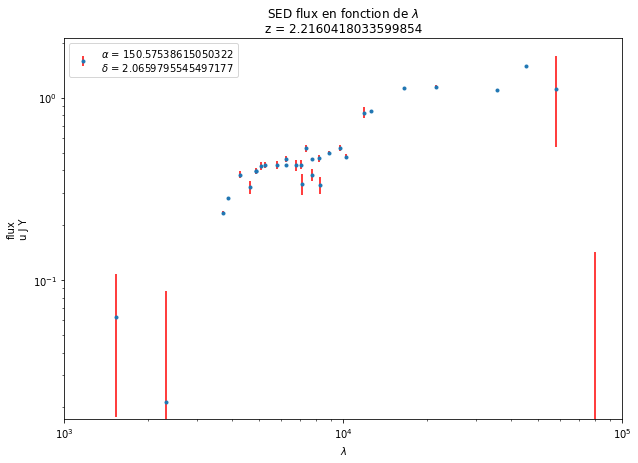

In [39]:
### SED flux autour de G237

# Coordonnées de G237 :
alpha_G237 = 150.507                      
delta_G237 = 2.31204                     
size_G237 = 12 * 5.5 / (60*60)

# Il faudrait sélectionner les galaxies comprises dans la taille de G237, voir légèrement plus

alpha_max = alpha_G237 + 12/60
delta_max = delta_G237 + 5.5/60

# Filtre des valeurs masquées
for i in filt_name:
    if i+'_FLUX' in cat_croiss_z.keys():
        mask_i = cat_croiss_z[i+'_FLUX'].mask
        cat_croiss_z = cat_croiss_z[~mask_i]

# Créer un masque booléen pour les conditions
mask = (cat_croiss_z["alpha"] >= alpha_G237 - alpha_max) & (cat_croiss_z["alpha"] <= alpha_G237 + alpha_max) & \
       (cat_croiss_z["delta"] >= delta_G237 - delta_max) & (cat_croiss_z["delta"] <= delta_G237 + delta_max)

# Appliquer le masque pour sélectionner les valeurs correspondantes
# selected_alpha = cat_croiss_z["alpha"][mask]
# selected_delta = cat_croiss_z["delta"][mask]

# Création de l'objet PdfPages pour sauvegarder les graphes dans un fichier PDF
with PdfPages('G237_SED_flux_z_2_2.3.pdf') as pdf:
    indices = np.where((cat_croiss_z["z"][mask] > 2) & (cat_croiss_z["z"][mask] < 2.3))[0]

    for index in indices:
        j = cat_croiss_z["z"][mask][index]
        alpha_value = cat_croiss_z['alpha'][mask][index]
        delta_value = cat_croiss_z['delta'][mask][index]
        wave_len, flux, flux_err = [], [], []
        empty_key, used_key = [], []

        for i in filt_name:
            if i+'_FLUX' in cat_croiss_z.keys():
                used_key.append(i+'_FLUX')
                indices = np.where(cat_croiss_z["z"] == j)[0]
                wave_len.extend(filt_dict[i][0] for k in indices)
                flux.extend(cat_croiss_z[i+'_FLUX'][indices])
                flux_err.extend(cat_croiss_z[i+'_FLUXERR'][indices])
            else:
                empty_key.append(i+'_FLUX')

        fig = plt.figure(figsize=(10, 7))
        plt.errorbar(wave_len, flux, yerr=flux_err, linestyle='None', marker='.', ecolor='red' , label="$\\alpha$ = {}\n$\\delta$ = {}".format(alpha_value,delta_value))
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel("$\lambda$")
        plt.ylabel("flux\nu J Y")
        plt.xticks([1000,10000,100000])
        plt.title("SED flux en fonction de $\lambda$\nz = {}".format(j))
        plt.legend()
        # plt.show()

        pdf.savefig(fig)
        plt.close(fig)  # Fermeture explicite de la figure pour libérer la mémoire


In [ ]:
### SED mag AB autour de G237

# Je ne suis pas certain que ce soit correct car la cellule de conversion des flu mag AB semblent ne pas fonctionner

# Coordonnées de G237 :
alpha_G237 = 150.507                      
delta_G237 = 2.31204                     
size_G237 = 12 * 5.5 / (60*60)

# Il faudrait sélectionner les galaxies comprises dans la taille de G237, voir légèrement plus

alpha_max = alpha_G237 + 12/60
delta_max = delta_G237 + 5.5/60

# Filtre des valeurs masquées
for i in filt_name:
    if i+'_MAG' in cat_croiss_z.keys():
        mask_i = cat_croiss_z[i+'_MAG'].mask
        cat_croiss_z = cat_croiss_z[~mask_i]

# Créer un masque booléen pour les conditions
mask = (cat_croiss_z["alpha"] >= alpha_G237 - alpha_max) & (cat_croiss_z["alpha"] <= alpha_G237 + alpha_max) & \
       (cat_croiss_z["delta"] >= delta_G237 - delta_max) & (cat_croiss_z["delta"] <= delta_G237 + delta_max)

# Appliquer le masque pour sélectionner les valeurs correspondantes
# selected_alpha = cat_croiss_z["alpha"][mask]
# selected_delta = cat_croiss_z["delta"][mask]

# Création de l'objet PdfPages pour sauvegarder les graphes dans un fichier PDF
with PdfPages('G237_SED_mag_z_2_2.3.pdf') as pdf:
    indices = np.where((cat_croiss_z["z"][mask] > 2) & (cat_croiss_z["z"][mask] < 2.3))[0]

    for index in indices:
        j = cat_croiss_z["z"][mask][index]
        alpha_value = cat_croiss_z['alpha'][mask][index]
        delta_value = cat_croiss_z['delta'][mask][index]
        wave_len, flux, flux_err = [], [], []
        empty_key, used_key = [], []

        for i in filt_name:
            if i+'_MAG' in cat_croiss_z.keys():
                used_key.append(i+'_MAG')
                indices = np.where(cat_croiss_z["z"] == j)[0]
                wave_len.extend(filt_dict[i][0] for k in indices)
                flux.extend(cat_croiss_z[i+'_MAG'][indices])
                flux_err.extend(cat_croiss_z[i+'_MAGERR'][indices])
            else:
                empty_key.append(i+'_MAG')

        fig = plt.figure(figsize=(10, 7))
        plt.errorbar(wave_len, flux, yerr=flux_err, linestyle='None', marker='.', ecolor='red' , label="$\\alpha$ = {}\n$\\delta$ = {}".format(alpha_value,delta_value))
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel("$\lambda$")
        plt.ylabel("mag")
        plt.title("SED MAG AB en fonction de $\lambda$\nz = {}".format(j))
        plt.legend()
        # plt.show()

        pdf.savefig(fig)
        plt.close(fig)  # Fermeture explicite de la figure pour libérer la mémoire
